In [1]:
from esmvalcore.dataset import Dataset

In [2]:
model_datasets = {
"ACCESS-ESM1-5": 
    Dataset(
    short_name='tos',
    project='CMIP6',
    mip="Omon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="19780101/20190101", ##rolling window
    dataset="ACCESS-ESM1-5",
    grid="gn"
)}
model_datasets["ACCESS-ESM1-5"].add_supplementary(short_name='areacello', mip='Ofx')

obs_datasets = {
"HadISST": 
    Dataset(
    short_name='tos',
    dataset='HadISST',
    mip="Omon",
    project='OBS',
    type='reanaly',
    tier=2),
"ERSSTv5":
    Dataset(
    short_name='tos',
    dataset='NOAA-ERSSTv5',
    mip="Omon",
    project='OBS6',
    type='reanaly',
    tier=2),
# "ERA-Interim": 
#     Dataset(
#     short_name='tos',
#     dataset='ERA-Interim',
#     mip="Omon",
#     project='OBS',
#     type='reanaly',
#     timerange="19790101/20190101",
#     tier=3)
}

In [3]:
model_datasets = {name: dataset.load() for name, dataset in model_datasets.items()}
obs_datasets = {name: dataset.load() for name, dataset in obs_datasets.items()}

In [4]:
from esmvalcore.preprocessor import anomalies
from esmvalcore.preprocessor import area_statistics
from esmvalcore.preprocessor import rolling_window_statistics
from esmvalcore.preprocessor import meridional_statistics
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import extract_month
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import mask_landsea
import iris

import matplotlib.pyplot as plt
import iris.quickplot as qplt
import numpy as np
import xarray as xr
import sacpy as scp
from esmvalcore.iris_helpers import date2num 
# [d for d in t_coord.units.num2date(t_coord.points)]

In [5]:
def sst_enso_n34(cube):
    nino34_latext_region = {"start_longitude": 190., "end_longitude": 240., "start_latitude": -5., "end_latitude": 5.}
    cube = convert_units(cube, units="degC")
    # cube = mask_landsea(cube, mask_out="land") #shp or land fraction
    cube = extract_region(cube, **nino34_latext_region)
    # #remove time mean
    cube = anomalies(cube, period='monthly') 
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)##rolling window cuts off months?
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    cube = area_statistics(cube,operator='mean')
    # cube = extract_month(cube,12) # select after
    # detrend?
    return cube

def sst_meridional(cube): ##along latitude for area
    nino34_latext_region = {"start_longitude": 160., "end_longitude": 280., "start_latitude": -5., "end_latitude": 5.}
    cube = convert_units(cube, units="degC")
    #mask
    cube = anomalies(cube, period='monthly')
    cube = extract_region(cube, **nino34_latext_region)
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = meridional_statistics(cube,operator='mean')
    return cube

#rmse

In [6]:
model_datasets_prep1 = {name: sst_enso_n34(dataset) for name, dataset in model_datasets.items()}
model_datasets_prep2 = {name: sst_meridional(dataset) for name, dataset in model_datasets.items()}

obs_datasets_prep1 = {name: sst_enso_n34(dataset) for name, dataset in obs_datasets.items()}
obs_datasets_prep2 = {name: sst_meridional(dataset) for name, dataset in obs_datasets.items()}


/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4620: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/coords.py:2153: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'cell index along second dimension', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'cell index along second dimension'. Ignoring bounds.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/coords.py:2153: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'cell index along first dimension', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully d

In [7]:
# 
def sst_regressed(n34_dec, n34, n34_area):
    leadlagyr = 3 #rolling window cut off, not include first year
    n34_dec_ct = n34_dec[leadlagyr:-leadlagyr]
    event_years = n34_dec_ct.time.dt.year #
    # Ensure that the selected years are not the last or second last year in the n34 dataset
    years_of_interest_array = []
    
    # Fill the array with the years of interest for each event year 
    for i, year in enumerate(event_years):# 2:-3 for dec        
        years_of_interest_array.append([year.values - 2, year.values - 1, year.values, year.values + 1, year.values + 2, year.values + 3])
    
    n34_selected = []
    n34_area_selected = []
    for i in range(len(years_of_interest_array)): #creates sst_time_series
        # Select the data for the current year and append it to n34_selected #n34 is not dec month only
        n34_selected.append(n34.sel(time=n34['time.year'].isin(years_of_interest_array[i])))
        n34_area_selected.append(n34_area.sel(time=n34_area['time.year'].isin(years_of_interest_array[i])))

    # 1) linear regression of sst_time_series on sst_enso
    slope = scp.LinReg(n34_dec_ct.values, n34_selected).slope
    slope_area = scp.LinReg(n34_dec_ct.values, n34_area_selected).slope

    return slope, slope_area

In [8]:
model_n34 = model_datasets_prep1["ACCESS-ESM1-5"]
model_n34_dec = extract_month(model_datasets_prep1["ACCESS-ESM1-5"],12)
model_n34_area = model_datasets_prep2["ACCESS-ESM1-5"]


obs_n34 = obs_datasets_prep1["HadISST"]
obs_n34_dec = extract_month(obs_datasets_prep1["HadISST"],12)
obs_n34_area = obs_datasets_prep2["HadISST"]


In [9]:
## metric computation - rmse of slopes
cb_out = {'nino34':model_n34, 'n34_dec':model_n34_dec, 'n34_area':model_n34_area}
darray_dict = {cbname: xr.DataArray.from_iris(cb) for cbname, cb in cb_out.items()}

model = sst_regressed(darray_dict['n34_dec'], darray_dict['nino34'], darray_dict['n34_area'])
## obs
cb_out = {'nino34':obs_n34, 'n34_dec':obs_n34_dec, 'n34_area':obs_n34_area}
darray_dict = {cbname: xr.DataArray.from_iris(cb) for cbname, cb in cb_out.items()}
obs = sst_regressed(darray_dict['n34_dec'], darray_dict['nino34'], darray_dict['n34_area'])

rmse = np.sqrt(np.mean((obs[0] - model[0]) ** 2))
rmse

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/sacpy/linger_cal.py:45: RuntimeWarning: invalid value encountered in sqrt
  t = corr / (np.sqrt(1 - corr**2) + EPS) * np.sqrt(Num0 - 2)


0.2396293

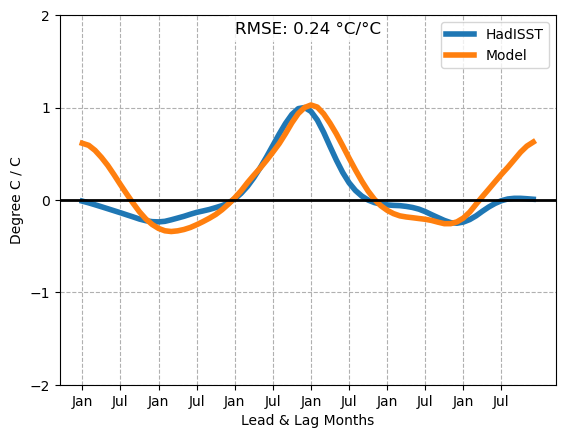

In [10]:
months = np.arange(1, 73) - 36

# Plot the slope
plt.plot(months, obs[0], label='HadISST', lw=4)
plt.plot(months, model[0], label='Model', lw=4)

# Draw a black dashed line at y=0.25
# plt.axhline(y=0.25, color='black', linestyle='--', label='0.25 threshold')

# Draw a thicker line at y=0
plt.axhline(y=0, color='black', linewidth=2) #, label='Zero Line')

# Define custom ticks for the x-axis (every 6 months)
xticks = np.arange(1, 73, 6) - 36  # Adjust for lead/lag months
xtick_labels = ['Jan', 'Jul'] * (len(xticks) // 2)

# Set the labels and titles
plt.xlabel('Lead & Lag Months')
plt.ylabel('Degree C / C')
plt.legend()
plt.grid(linestyle='--')

# Apply the custom ticks and labels to the x-axis
plt.xticks(xticks, xtick_labels)
plt.yticks(np.arange(-2,2.5, step=1))

# Adding RMSE text on top of the plot
plt.text(0.5, 0.95, f'RMSE: {rmse:.2f} °C/°C', fontsize=12, ha='center', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
# Show the plot
plt.show()

# Dive down Level 2:

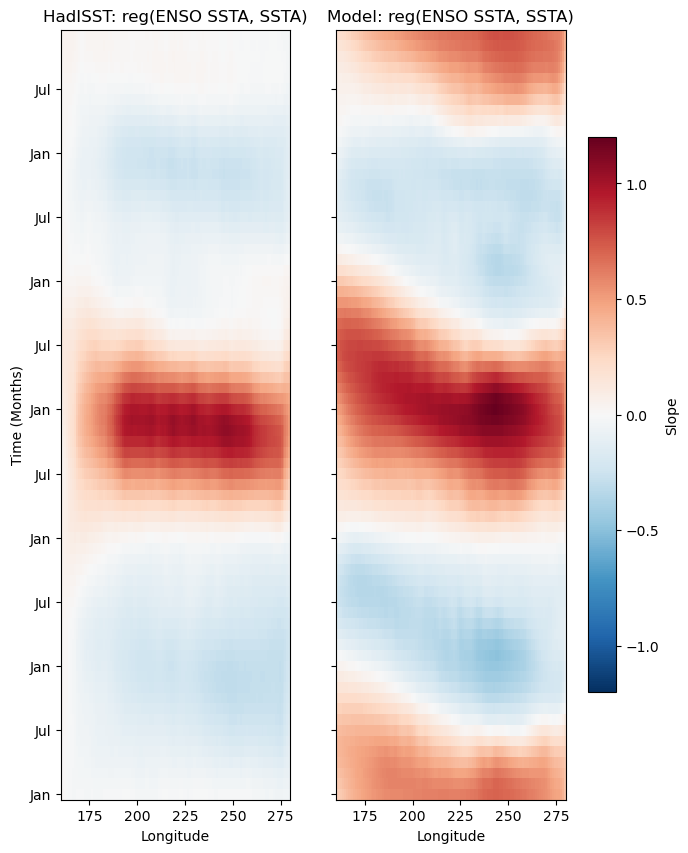

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Define custom ticks for the y-axis (every 6 months)
yticks = range(1, 73, 6)
ytick_labels = ['Jan', 'Jul'] * (len(yticks) // 2)

# Define shared color limits for both subplots
vmin = -1.2 # min(np.min(slope_area), np.min(obs_slope_area))
vmax = 1.2 # max(np.max(slope_area), np.max(obs_slope_area))

# Create the subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 10), sharey=True)

# First subplot obs[0] - model[0]
c1 = ax1.pcolormesh(obs_n34_area.coord('longitude').points, range(1, 73), obs[1], shading='auto', cmap='RdBu_r', vmin=vmin, vmax=vmax)
ax1.set_ylabel('Time (Months)')
ax1.set_xlabel('Longitude')
ax1.set_xlim([160,280])
ax1.set_title('HadISST: reg(ENSO SSTA, SSTA)')
ax1.set_yticks(yticks)
ax1.set_yticklabels(ytick_labels)

# Second subplot
c2 = ax2.pcolormesh(model_n34_area.coord('longitude').points, range(1, 73), model[1], shading='auto', cmap='RdBu_r', vmin=vmin, vmax=vmax)
ax2.set_xlabel('Longitude')
ax2.set_title('Model: reg(ENSO SSTA, SSTA)')
ax2.set_xlim([160,280])

# Adjust the layout to add more space for the colorbar on the right
plt.subplots_adjust(right=1.05)

# Add a colorbar and position it slightly to the right of the plots
cbar = fig.colorbar(c1, ax=[ax1, ax2], label='Slope', orientation='vertical', fraction=0.05, pad=0.04)

# Display the plot
# plt.tight_layout()
#plt.show()
